In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

#### Prepare for Dataset

In [2]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('../Data/shakespeare.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [3]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cpu


#### Network Definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.hidden_layer = nn.RNNCell(self.input_size,self.hidden_size) 
        self.output_layer = nn.Linear(self.hidden_size,self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        hidden = self.hidden_layer(input,hidden)
        output = self.output_layer(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (hidden_layer): RNNCell(100, 100)
  (output_layer): Linear(in_features=100, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [6]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [7]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [8]:
iters       = 20000  # Number of training iterations.
print_iters = 200    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.SGD(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:199/20000 loss:3.1961145401000977
generated sequence: W xef bn thsbe than ugtart tiyre
Aed tu&ul toreleiyerb

:;vin ynsr sd na,e mad zcymstletzou'use:
foic

iter:399/20000 loss:2.7196567058563232
generated sequence: Weo'im andor heely thalcs5orce.;, wheu toH youg /ou mid| latG
Zn'ghin dia	g.
He shald thed
Bn sharr.


iter:599/20000 loss:2.5930914878845215
generated sequence: W pamene

Anowis, ferpall an have vo the it ou sof ou hayfllo fo fanc yolllr woinse
xser 9oll ghimd b

iter:799/20000 loss:5.3034467697143555
generated sequence: WhririririrircrSrlrirorHr6rcrorororirqrhrdrcrhriryrdr
rcrcrcrircrGr
rcrir
rcrhrir.rorirProrircr

iter:999/20000 loss:14.247803688049316
generated sequence: W:s s i i o U i i i i i i i i i o i i i i i o o i i i i i i i i s i i i o o E o s i o i i o i i i i i

iter:1199/20000 loss:12.273941993713379
generated sequence: Wm::n,nanangnananEnanknananandnan	nanMnOr:nanananantnanananantnan#n'nanan0nanananananananpnananananan

iter:1399/20000 loss:8.9571905136

#### Training Loss Curve

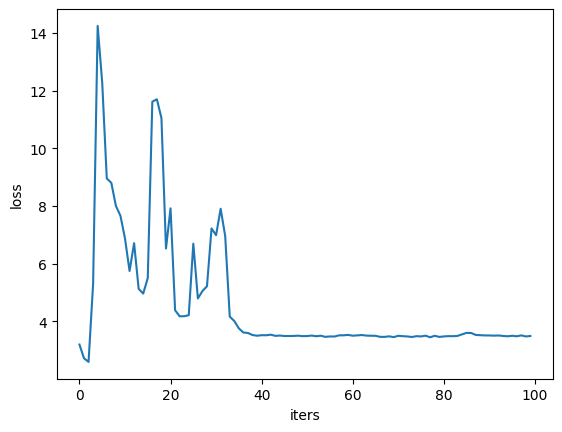

In [9]:
plt.xlabel('iters')
plt.ylabel('loss')
all_losses = [loss.item() for loss in all_losses]
plt.plot(np.array(all_losses))
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [10]:
print(eval_step(net, predicted_len=600))

W ow;rdhie,une 
rearaaNa; m i ui e s
etse: gnao  s hqsfd,ohGmt;tkt an  S ioRtHwnw
asthufhth et   dt 
btfi  thhm,naatI mthCeoDlyaesdr pOurdu rhostemogdfrehonuLro masa
 EraswTehkgCnhsryaC
o
-htl'sfovhnEtlrteuCt ktn r r! ehklneeadd s  nBbe ushoThmgntTmt,aht
 Ihrhdewni  e Ovah
tsteie
ne taen"t Uye abemfggrhtAKrowcrehl rnLm'katmaselihtar nsarOssh mih ,sT d  on.od iewFdeQBmaetae i tItaor
rmchumnh nfhle,aae in,
lc tutml;hMueurclctg s,eaE 
uvnfe,ov ahnhri,elUotmnwre hwskn:aterGf hsadra' l  o nioese bYs fe~ ee
r ajhoBse h omt r' eIr  m ee`ceelwRl t s) ruo dh: truE ho duB
eunoheefh  :au yem  tgrntanrehou


### Method 
I employ a similar method to the original rnn we implemented to predict the next character. The only difference is that I used the stochastic gradient descent optimizer. 

### Evaluation

Compared to the adam optimizer, this a poor choice. The metric I use to evaluate how sensible the output is by seeing how close each part of the generated sequence resembles words in English. Since the output was mostly a bunch of scambled characters that had no semantic meaning, this optimizer did not do a good job.